In [ ]:
# -*- coding: utf-8 -*-
# @Desc: Example to show how to use tools in index benchmark generate distribution drift data

# set workspace to the root of the project
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

import numpy as np
from neuralbench.index.util import load_key_set, KeyType
from neuralbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neuralbench.drift import find_q

In [2]:
# load key set
keyset_file_path = "/users/lingze/TLI/data/wiki_ts_200M_uint64"
data = load_key_set(keyset_file_path)

In [3]:
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
data_type

<KeyType.UINT64: 'uint64'>

In [4]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal key.
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "CONFIDENCE", verbose=True)

Filtered 8588096 values, [191411905 / 200000001]


In [5]:
"""Bin the key set, to get the distribution of keyset.
heuristically choose the bin size (offset), to possibly control the number of bins around 100.
we can plot the figure to see the distribution of key set.
"""
_, prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(keys, bin_width_offset = 20, verbose = True, details = False)

Total number of bins: 109


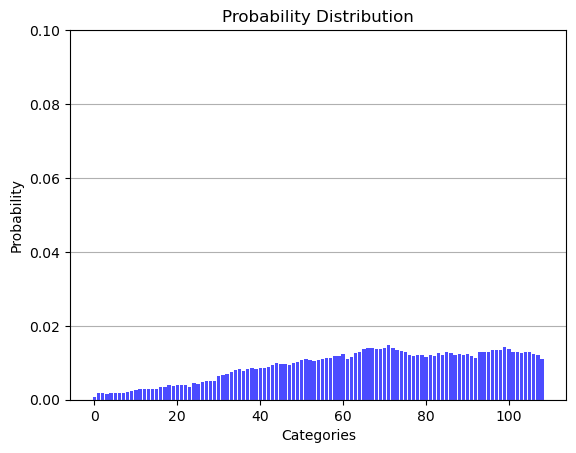

In [6]:
KeySetBinEncoder.plot_probability_distribution(prob)

In [7]:
"""When we heuristically choose the bin size, and check the plot it is okay.
We can set the details to True for subsequent sample.
"""
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(keys, bin_width_offset = 20, verbose = True)

Total number of bins: 109


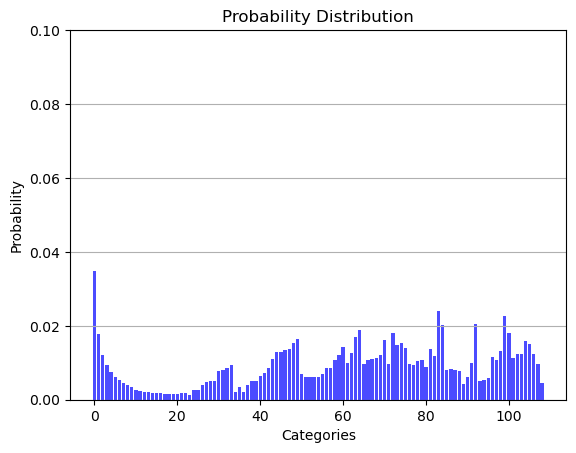

In [8]:
""" assign a drift rate alpha to get the initial distribution of key set.
and draw the figure
"""
init_prob = find_q(prob, 0.2, skewed= True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [9]:
"""sample the bulkloading keyset, given a bulkloading keyset size.
"""
bulkloading_ratio = 0.6
n = len(data)
bulkloading_n = int(n * bulkloading_ratio)

bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)

Exceeding the number of keys in bin 1051, sample_n: 4176680, bound_n: 122399
Exceeding the number of keys in bin 1052, sample_n: 2141623, bound_n: 368291
Exceeding the number of keys in bin 1053, sample_n: 1461495, bound_n: 337574
Exceeding the number of keys in bin 1054, sample_n: 1123339, bound_n: 279080
Exceeding the number of keys in bin 1055, sample_n: 898506, bound_n: 353889
Exceeding the number of keys in bin 1056, sample_n: 751566, bound_n: 358318
Exceeding the number of keys in bin 1057, sample_n: 651118, bound_n: 329405
Exceeding the number of keys in bin 1058, sample_n: 558732, bound_n: 364066
Exceeding the number of keys in bin 1059, sample_n: 480403, bound_n: 397938
Exceeding the number of keys in bin 1100, sample_n: 1964889, bound_n: 1934473
Exceeding the number of keys in bin 1134, sample_n: 2870398, bound_n: 2408374
Exceeding the number of keys in bin 1135, sample_n: 2413961, bound_n: 2337527
Exceeding the number of keys in bin 1143, sample_n: 2473736, bound_n: 2151867


In [13]:
# true bulkloading numbers
len(bulkloading_keys) / n

0.5488835072555824

In [14]:
insert_keys = np.setdiff1d(data, bulkloading_keys)

In [16]:
# convert to np.ndarray with specific data type
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())
insert_keys = np.array(insert_keys, dtype = data_type.to_numpy_type())
# save these two key sets as binary files
bulkloading_file_path = "./data/index/wiki_ts_200M_uint64_bulkloading"
insert_file_path = "./data/index/wiki_ts_200M_uint64_insert"

bulkloading_keys.tofile(bulkloading_file_path)
insert_keys.tofile(insert_file_path)

In [18]:
# check can we read it correctly

bulkloading_keys = np.fromfile(bulkloading_file_path, dtype = data_type.to_numpy_type())